In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.systems import V1Circuit
from dsn.util.dsn_util import get_savedir
from dsn.util.plot_util import assess_constraints, plot_opt, dsn_pairplots, \
                               pairplot, lin_reg_plot
from tf_util.stat_util import approx_equal
import matplotlib.backends.backend_pdf

import os

os.chdir('../../')

In [2]:
EPS = 1e-16

# normalizing flow layer architecture
flow_type = 'PlanarFlow'
# number of layers
K = 10
nlayers = 10
sigma0 = 0.1
s = 5

dirstr = 'V1Circuit'

# create an instance of the V1_circuit system class
base_I = 0.15
run_I = 0.3
tau = 0.15

fixed_params = {'b_E':base_I, \
                'b_P':base_I, \
                'b_S':base_I, \
                'b_V':base_I, \
                'h_RUNE':run_I, \
                'h_RUNP':run_I, \
                'h_RUNS':run_I, \
                'h_RUNV':run_I, \
                'h_FFE':0.0, \
                'h_FFP':0.0, \
                'h_LATE':0.0, \
                'h_LATP':0.0, \
                'h_LATS':0.0, \
                'h_LATV':0.0, \
                'tau':tau, \
                'n':2.0, \
                's_0':30};

behavior_type = "difference"

c_vals=np.array([1.0])
s_vals=np.array([s])
r_vals=np.array([0.0, 1.0])
fac = 10.0
behavior = {'type':behavior_type, \
            'c_vals':c_vals, \
            's_vals':s_vals, \
            'r_vals':r_vals, \
            'fac':fac}

# set model options
model_opts = {"g_FF": "c", "g_LAT": "square", "g_RUN": "r"}
T = 50
dt = 0.05
init_conds = np.expand_dims(np.array([1.0, 1.1, 1.2, 1.3]), 1)

system = V1Circuit(fixed_params, behavior, model_opts, T, dt, init_conds)

arch_dict = {'D':system.D, \
             'K':K, \
             'flow_type':flow_type, \
             'sigma0':sigma0, \
             'repeats':nlayers, \
             'post_affine':True}


lr_order = -3

{'type': 'difference', 'c_vals': array([1.]), 's_vals': array([5]), 'r_vals': array([0., 1.]), 'fac': 10.0}


In [3]:
print(system.mu)

[ 7.56691135e-02  8.09665732e-02 -1.33347121e-03  9.09914169e-02
  5.76829976e-03  6.67799020e-03  3.75602521e-05  8.32453359e-03]


T_xs (1001, 200, 8)
al final
[None]


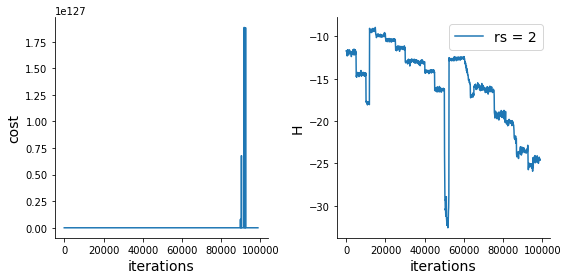

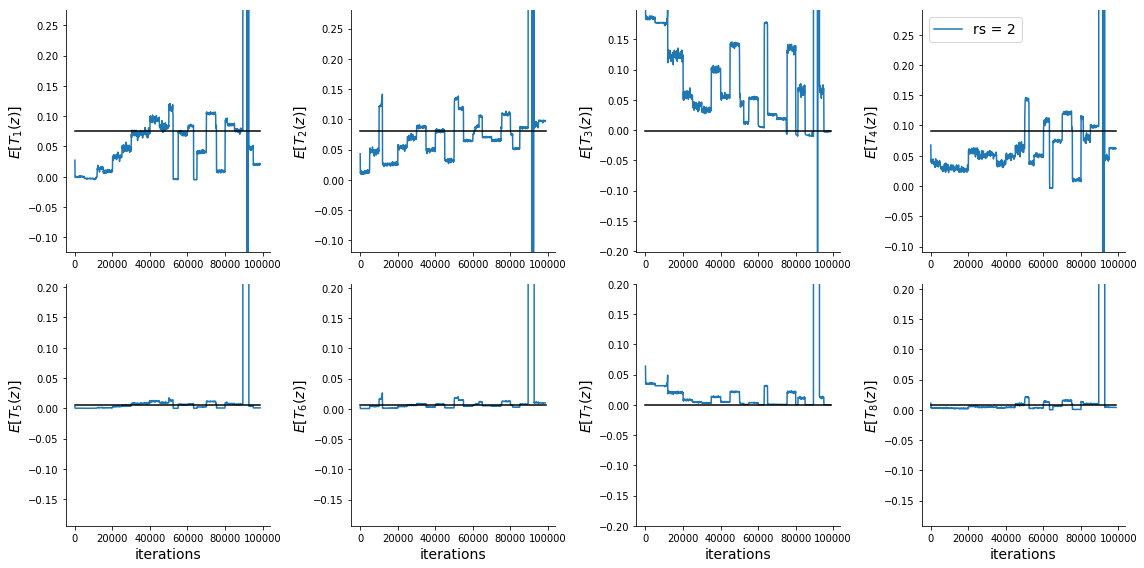

In [5]:
# multivariate normal initialization variance
sigma_init = 1.0
c_init_order = 0

start_rs = 2
num_rs = 1
random_seeds = np.arange(start_rs, num_rs+start_rs)

basedir = '/Users/sbittner/Documents/dsn/dsn/'
model_dirs = []
legendstrs = []
for i in range(num_rs):
    random_seed = random_seeds[i]
    dsndir = basedir + get_savedir(system, arch_dict, sigma_init, c_init_order, random_seed, dirstr)
    fname = dsndir + 'opt_info.npz'
    model_dirs.append(dsndir)
    legendstrs.append('rs = %d' % random_seed)
    
alpha = 0.05
frac_samps = 0.5
    
figs, AL_final_its, p_values = plot_opt(model_dirs, legendstrs, con_method='1', frac_samps=frac_samps, maxconlim=0.2)


In [7]:
print(system.mu)

[ 7.56691135e-02  8.09665732e-02 -1.33347121e-03  9.09914169e-02
  5.76829976e-03  6.67799020e-03  3.75602521e-05  8.32453359e-03]


In [8]:
if (num_rs == 1):
    npzfile = np.load(fnames[0])
    it_converge = npzfile['check_rate']*AL_final_its[0]
    fontsize = 25;
    Hs = npzfile['Hs'];
    check_rate = npzfile['check_rate'];
    last_ind = npzfile['it']//check_rate;
    nits = npzfile['costs'].shape[0];
    iterations = np.arange(0, check_rate*nits, check_rate);
    fig = plt.figure();
    ax = fig.add_subplot(111);
    plt.plot(iterations[:last_ind], Hs[:last_ind]);
    print(Hs.shape)
    print(np.min(Hs.shape))
    plt.plot([it_converge, it_converge], [np.min(Hs), np.max(Hs)], 'k--');
    ax.set_xlabel('iterations', fontsize=fontsize);
    ax.set_ylabel(r'$H(q_\phi)$', fontsize=fontsize);
    ax.set_xticks([0, 40000, 80000])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.show();

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

In [46]:
fontsize = 18
ylims = [-1, 4]
yscale_fac = 5
if (num_rs == 1):
    npzfile = np.load(fnames[0])
    it_converge = npzfile['check_rate']*AL_final_its[0]
    mean_T_xs = npzfile['mean_T_xs'];
    mu = npzfile['mu']
    T_xs = npzfile['T_xs'];
    n_suff_stats = mean_T_xs.shape[1];
    n_cols = 4;
    n_rows = int(np.ceil(n_suff_stats/n_cols));
    figsize = (n_cols*3, n_rows*3);
    fig2 = plt.figure(figsize=figsize);
    for i in range(n_suff_stats):
        ymin = mu[i]-.2
    
        ymax = mu[i]+.2
        ax = plt.subplot(n_rows,n_cols,i+1);
        ax.plot(iterations[:last_ind], mean_T_xs[:last_ind,i]);
        ax.plot([it_converge, it_converge], [ymin, ymax], 'k--')
        ax.plot([iterations[0], iterations[last_ind]], [mu[i], mu[i]], 'k--');
        ax.set_ylabel(r'E[%s]' % system.T_x_labels[i], fontsize=fontsize);
        if (i > n_suff_stats - n_cols - 1):
            ax.set_xlabel('iterations', fontsize=fontsize);
        ax.set_xticks([0, 40000, 80000])
        ax.set_ylim([ymin, ymax])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    plt.tight_layout();
    plt.show();

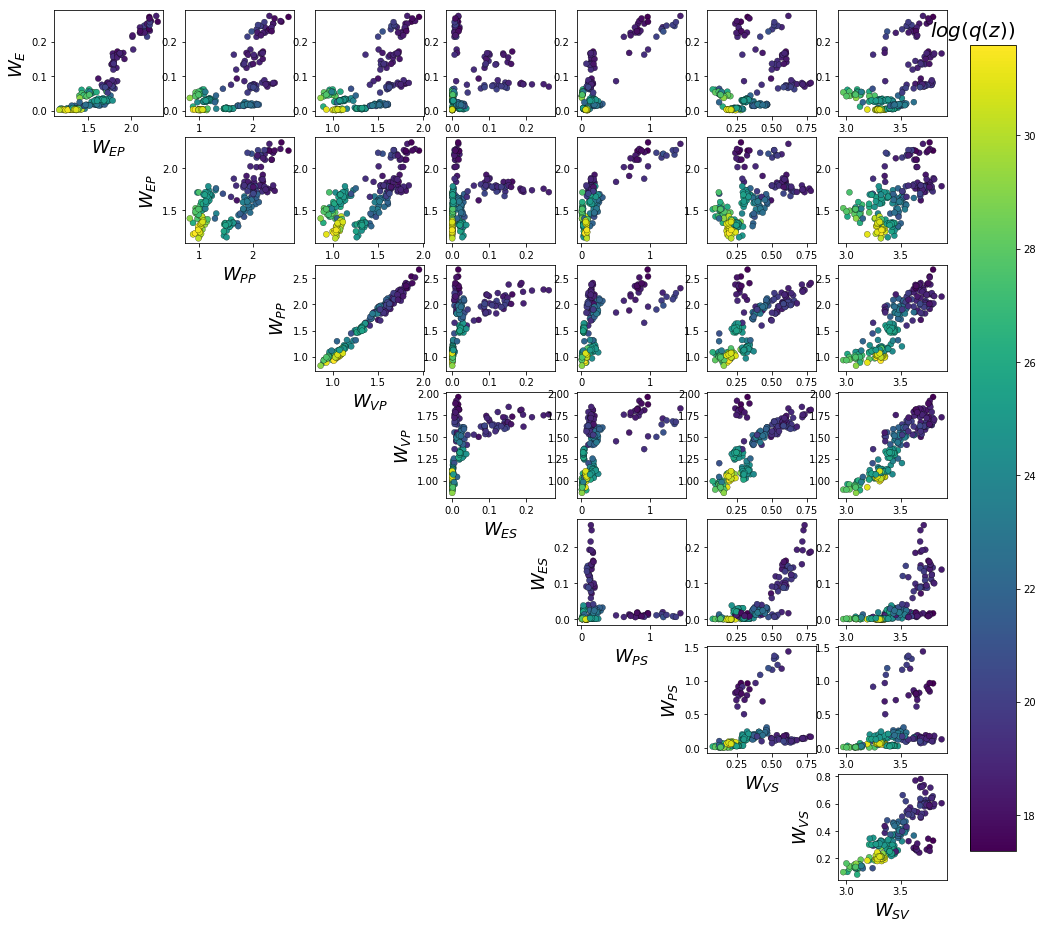

In [10]:
#pfname = 'images/V1_Zs_EPV_inc_S_same_logpz.png'
pfnames = ['z.png']
AL_final_its = [-1, -1]
dists = dsn_pairplots(fnames, 'Zs', system, system.D, f_str='identity', \
                      c_str='log_q_z', legendstrs=[], AL_final_its=AL_final_its, \
                      xlims=None, ylims=None, \
                      fontsize=18, ellipses=False, tri=True,
                      figsize=(16,16), pfnames=pfnames)


In [11]:
_Z = dists[0]
M = _Z.shape[0]
Z = tf.placeholder(tf.float64, (1, M, system.D))
r_t = system.simulate(Z)
W, b, h_FF, h_LAT, h_RUN, tau, n, s_0, a, c_50 = system.filter_Z(Z)

In [12]:
with tf.Session() as sess:
    _r_t, _W, _b, _h_RUN = sess.run([r_t, W, b, h_RUN], {Z:np.expand_dims(_Z, 0)})

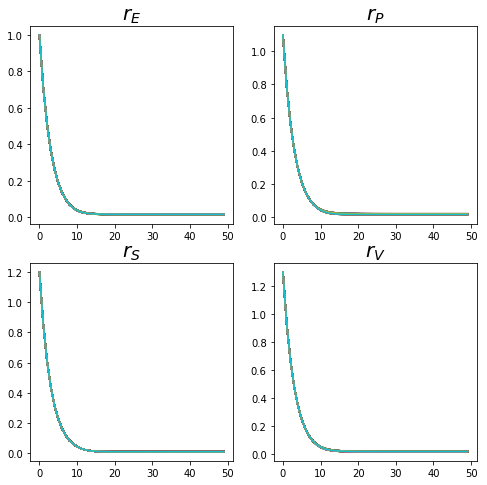

In [14]:
fontsize = 20
fig, axs = plt.subplots(2,2,figsize=(8,8))
axs[0,0].plot(_r_t[:,0, :, 0, 0])
axs[0,0].set_title(r'$r_E$', fontsize=fontsize)
axs[0,1].plot(_r_t[:,0, :, 1, 0])
axs[0,1].set_title(r'$r_P$', fontsize=fontsize)
axs[1,0].plot(_r_t[:,0, :, 2, 0])
axs[1,0].set_title(r'$r_S$', fontsize=fontsize)
axs[1,1].plot(_r_t[:,0, :, 3, 0])
axs[1,1].set_title(r'$r_V$', fontsize=fontsize)
plt.show()

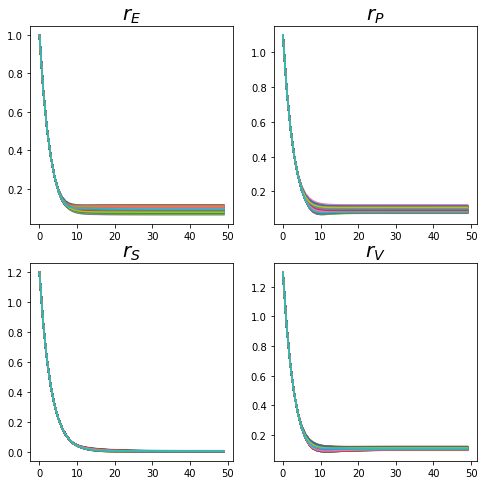

In [15]:
fontsize = 20
fig, axs = plt.subplots(2,2,figsize=(8,8))
axs[0,0].plot(_r_t[:,1, :, 0, 0])
axs[0,0].set_title(r'$r_E$', fontsize=fontsize)
axs[0,1].plot(_r_t[:,1, :, 1, 0])
axs[0,1].set_title(r'$r_P$', fontsize=fontsize)
axs[1,0].plot(_r_t[:,1, :, 2, 0])
axs[1,0].set_title(r'$r_S$', fontsize=fontsize)
axs[1,1].plot(_r_t[:,1, :, 3, 0])
axs[1,1].set_title(r'$r_V$', fontsize=fontsize)
plt.show()

In [21]:
print(_r_t.shape)
print(_b.shape, _h_RUN.shape)

(50, 2, 200, 4, 1)
(1, 200, 4, 1) (1, 200, 4, 1)


(2, 200, 4, 4) (4, 200, 50)


Text(0.5,1,'DSN samples')

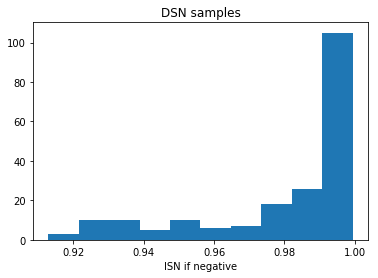

In [22]:
run = True

if (run):
    r_ss = _r_t[:,1,:,:,0].T
    print(_W.shape, r_ss.shape)
    u = np.zeros((M, 4))
    for i in range(M):
        u[i,:] = np.dot(_W[0,i,:,:], r_ss[:,i,-2]) + _h_RUN[0,i,:,0]
else:
    r_ss = _r_t[-1,0,:,:,0].T
    print(_W.shape, r_ss.shape)
    u = np.zeros((M, 4))
    for i in range(M):
        u[i,:] = np.dot(_W[0,i,:,:], r_ss[:,i,-2]) + _b[0,i,:,0]
r_ss = r_ss[:,:,-1]

uE = u[:,0].copy()
uE[uE < 0] = 0.0

plt.hist(1-2*u0*_Z[:,0])
plt.xlabel('ISN if negative')
plt.title('DSN samples')

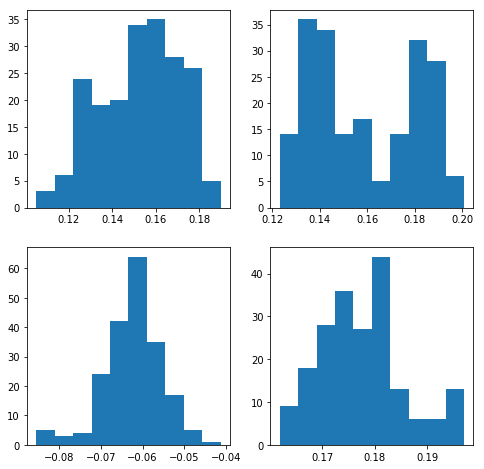

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(8,8))
axs[0][0].hist(u[:,0])
axs[0][1].hist(u[:,1])
axs[1][0].hist(u[:,2])
axs[1][1].hist(u[:,3])

plt.show()